# Generating enclosures

Algorithm to generate enclosed tessellation starts form the _enclosures_, continuous area of land enclosed form all sides by a barrier. In our case, barriers are roads, railways, rivers and a coastline. Although the algorithm itself can generate enclosures, it may be inefficient for large heterogenous GeoDataFrames. The criticial bottleneck is the `union` of all geometries before polygonizing them. That can be very expensive if the input data are not topologically clean. In the case of our barriers, they are non-topological by definition. To overcome this issue, we use two-step parallelized algorithm, which should in the end result in the same enclosures.

In [1]:
import os

import geopandas as gpd

from sqlalchemy import create_engine

user = os.environ.get('DB_USER')
pwd = os.environ.get('DB_PWD')
host = os.environ.get('DB_HOST')
port = os.environ.get('DB_PORT')

db_connection_url = f"postgres+psycopg2://{user}:{pwd}@{host}:{port}/built_env"
engine = create_engine(db_connection_url)

## Load data

In [94]:
x, y = 352125.32, 492802.86  # coordinates in epsg 27700
buffer = 5000  # radius in [m]

In [95]:
sql = f'SELECT * FROM openroads_200803_topological WHERE ST_DWithin(geometry, ST_SetSRID(ST_Point({x}, {y}), 27700), {buffer})'

roads = gpd.read_postgis(sql, engine, geom_col='geometry')

In [96]:
sql = f'SELECT * FROM openrivers_200909 WHERE ST_Intersects(geometry, ST_Buffer(ST_SetSRID(ST_Point({x}, {y}), 27700), {buffer}))'

rivers = gpd.read_postgis(sql, engine, geom_col='geometry')

In [97]:
sql = f'SELECT * FROM openmap_railwaytrack_200824 WHERE ST_Intersects(geometry, ST_Buffer(ST_SetSRID(ST_Point({x}, {y}), 27700), {buffer}))'

railway = gpd.read_postgis(sql, engine, geom_col='geometry')

<AxesSubplot:>

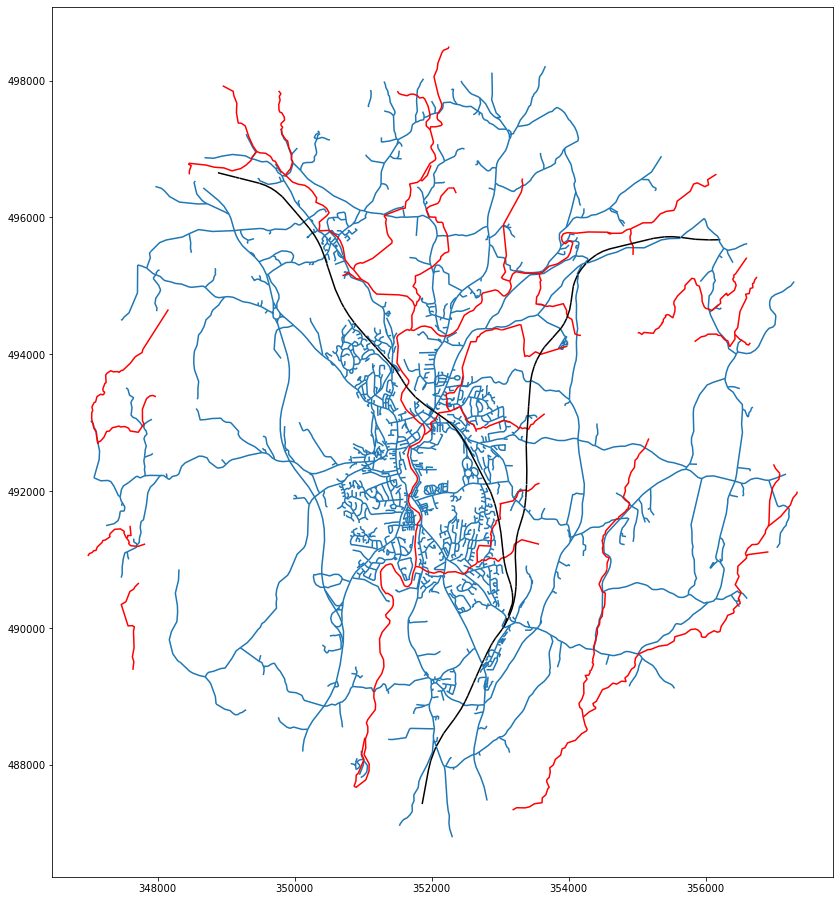

In [98]:
ax = roads.plot(figsize=(16, 16))
rivers.plot(ax=ax, color='r')
railway.plot(ax=ax, color='k')

## Snap railways to close the gaps

Railway network has gaps where it crosses roads, mostly because railway in those cases in under the bridge. These gaps cause issues during polygonization, as we need each enclosure to be fully closed. To overcome the issue, two preprocessing steps are introduced:

1. extend lines to road network to close the gap
2. snap railways to itself to ensure continuity of LineStrings

Rail network, even extended one, does not enclose area as we would need. Probably due to the floating point error, its conection to road network is sometimes (most of the times to be precise) seen as a gap. We have to preprocess railways further to snap segments to each other and generate contiguous topologically correct geometries.

In [99]:
from snap import line_to_line
from consolidate import topology
import pygeos

In [100]:
%%time
extended = line_to_line(railway, roads, 50)

CPU times: user 70.9 ms, sys: 0 ns, total: 70.9 ms
Wall time: 70.1 ms


In [101]:
%%time
extended_topo = topology(extended)

CPU times: user 21.8 ms, sys: 3.39 ms, total: 25.1 ms
Wall time: 22.8 ms


In [102]:
%%time
snapped = pygeos.snap(extended_topo.geometry.values.data, pygeos.union_all(extended_topo.geometry.values.data), 20)

CPU times: user 1.6 ms, sys: 104 µs, total: 1.7 ms
Wall time: 1.71 ms


In [103]:
%%time
rail_topo = topology(gpd.GeoDataFrame(geometry=snapped))

CPU times: user 14.3 ms, sys: 4.02 ms, total: 18.4 ms
Wall time: 16.9 ms


In [104]:
len(rail_topo), len(extended_topo)

(7, 22)

## Generate enclosures

### First level

We first generate enclosures defined by the external boundary of case study area and road network as a simple `polygonize` of combined geometries. That should be relatively cheap as there are almost no non-topological intersections between the layers.

In [105]:
from shapely.ops import polygonize
from shapely.geometry import Point
import pandas as pd

In [106]:
# get road-based polygons
limit = Point(x, y).buffer(buffer)

In [107]:
%%time
barriers = pd.concat([roads.geometry, gpd.GeoSeries([limit.boundary])])

CPU times: user 4.96 ms, sys: 61 µs, total: 5.02 ms
Wall time: 4.93 ms


In [108]:
%%time
unioned = barriers.unary_union

CPU times: user 41.5 ms, sys: 0 ns, total: 41.5 ms
Wall time: 40.9 ms


In [109]:
%%time
polygons = polygonize(unioned)
enclosures = gpd.array.from_shapely(list(polygons), crs=roads.crs)

CPU times: user 44.2 ms, sys: 13.3 ms, total: 57.5 ms
Wall time: 38.7 ms


<AxesSubplot:>

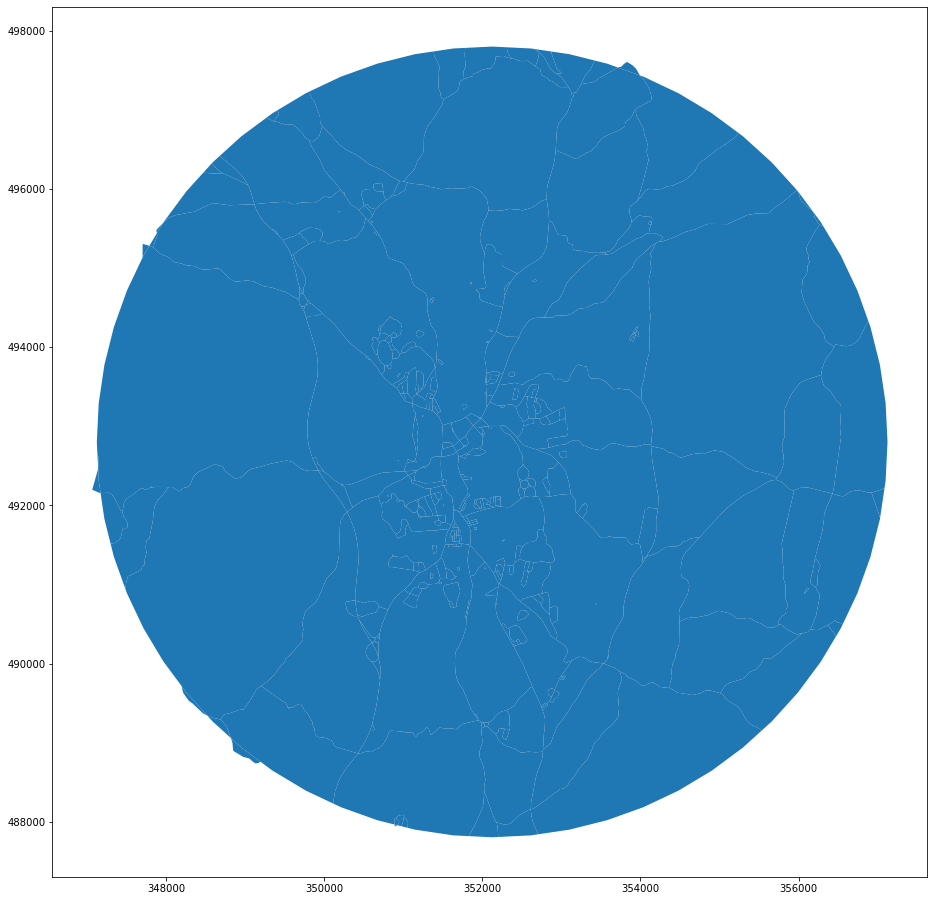

In [110]:
gpd.GeoSeries(enclosures).plot(figsize=(16, 16))

### Additional barriers

In the second step we loop through the road-based enclosures and check if that intersects any other barrier. If it does, we remove the original geometry and generate new one based on polygonization of goemetries of all barrier layers combined. This step might be a bit more expensive, but the loop can be parallelized and we are always working with a small set of geometries only.

In [111]:
additional = pd.concat([rivers.geometry, rail_topo.geometry])

In [112]:
add_sindex = additional.sindex

In [113]:
import numpy as np
from geopandas._vectorized import _pygeos_to_shapely

In [114]:
%%time
drop = []
new = []
for i, poly in enumerate(enclosures.data):
    crossing = add_sindex.query(poly, predicate='intersects')
    if crossing.size > 0:
        drop.append(i)
        union = pygeos.union_all(np.append(additional.values.data[crossing], pygeos.boundary(poly)))
        polygons = polygonize(_pygeos_to_shapely(union))
        new += list(polygons)

CPU times: user 53 ms, sys: 0 ns, total: 53 ms
Wall time: 52 ms


In [115]:
%%time
final_enclosures = gpd.GeoSeries(enclosures).drop(drop).append(gpd.GeoSeries(new))

CPU times: user 5.22 ms, sys: 0 ns, total: 5.22 ms
Wall time: 4.88 ms


<AxesSubplot:>

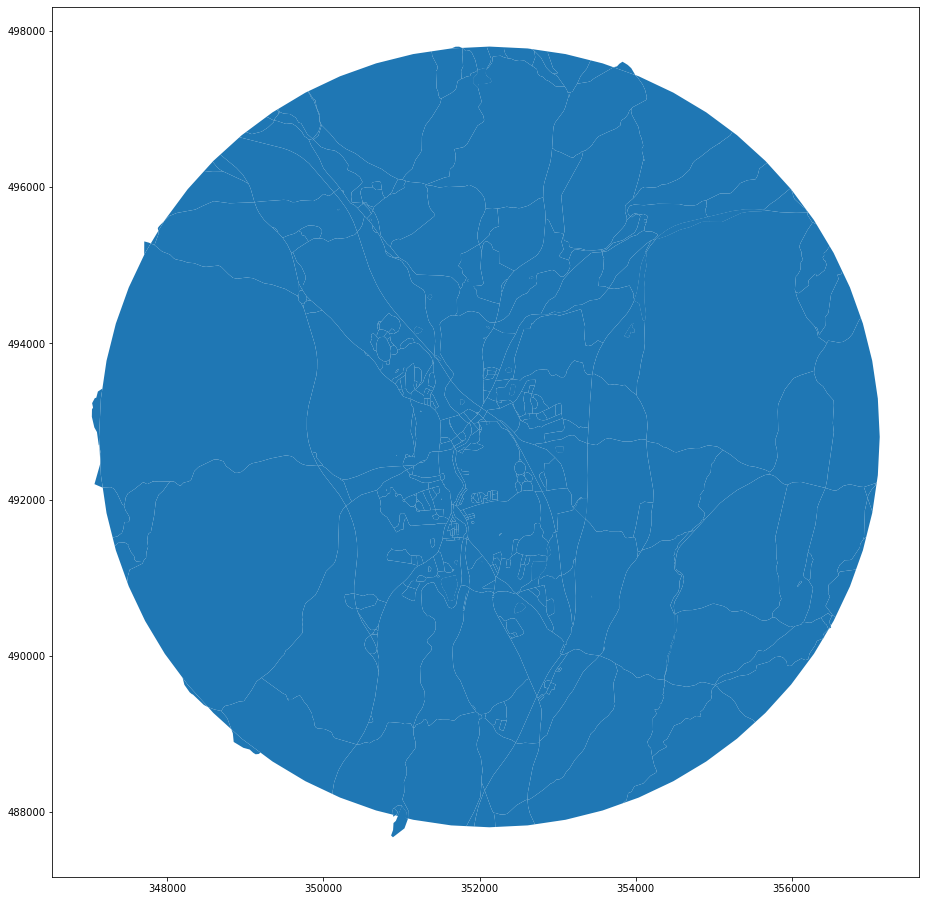

In [116]:
final_enclosures.plot(figsize=(16, 16))

We can further check how many polygons are removed and how many new are introduce, compared to the original count.

In [117]:
len(drop), len(new), len(enclosures), len(final_enclosures)

(63, 199, 378, 514)

## Parallel version using dask

The core of the method is the loop above. That can be easily parallelized using `dask`.

In [118]:
import dask.bag as db
from dask.distributed import Client
import itertools

We use a only local cluster for now.

In [119]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:43989 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 7 Cores: 28 Memory: 84.28 GB


To further vectorize our operations, we use `sindex.query_bulk` instead of querying within each iteration of the loop.

In [120]:
%%time
inp, res = gpd.GeoSeries(enclosures).sindex.query_bulk(additional.geometry, predicate='intersects')

CPU times: user 5.67 ms, sys: 0 ns, total: 5.67 ms
Wall time: 5.4 ms


We are interested only in enclosures which interect any other barrier (i.e. are present in `res`) and only once (i.e. unique values).

In [121]:
%%time
unique = np.unique(res)

CPU times: user 117 µs, sys: 15 µs, total: 132 µs
Wall time: 101 µs


The array of indices of unique polygons which need further subdivision is then converted into `dask.bag`.

In [122]:
bag = db.from_sequence(unique)

In [123]:
def divide(i):
    """Subdivide polygon `i` based on additional barriers.
    """
    poly = enclosures.data[i]
    crossing = inp[res==i]
    union = pygeos.union_all(np.append(additional.values.data[crossing], pygeos.boundary(poly)))
    polygons = polygonize(_pygeos_to_shapely(union))
    return list(polygons)

In [124]:
%%time
new = bag.map(divide).compute()

CPU times: user 658 ms, sys: 21.7 ms, total: 680 ms
Wall time: 1.27 s


In [125]:
%%time
final_enclosures = gpd.GeoSeries(enclosures).drop(drop).append(gpd.GeoSeries(list(itertools.chain.from_iterable(new))))

CPU times: user 4.47 ms, sys: 0 ns, total: 4.47 ms
Wall time: 4.04 ms


<AxesSubplot:>

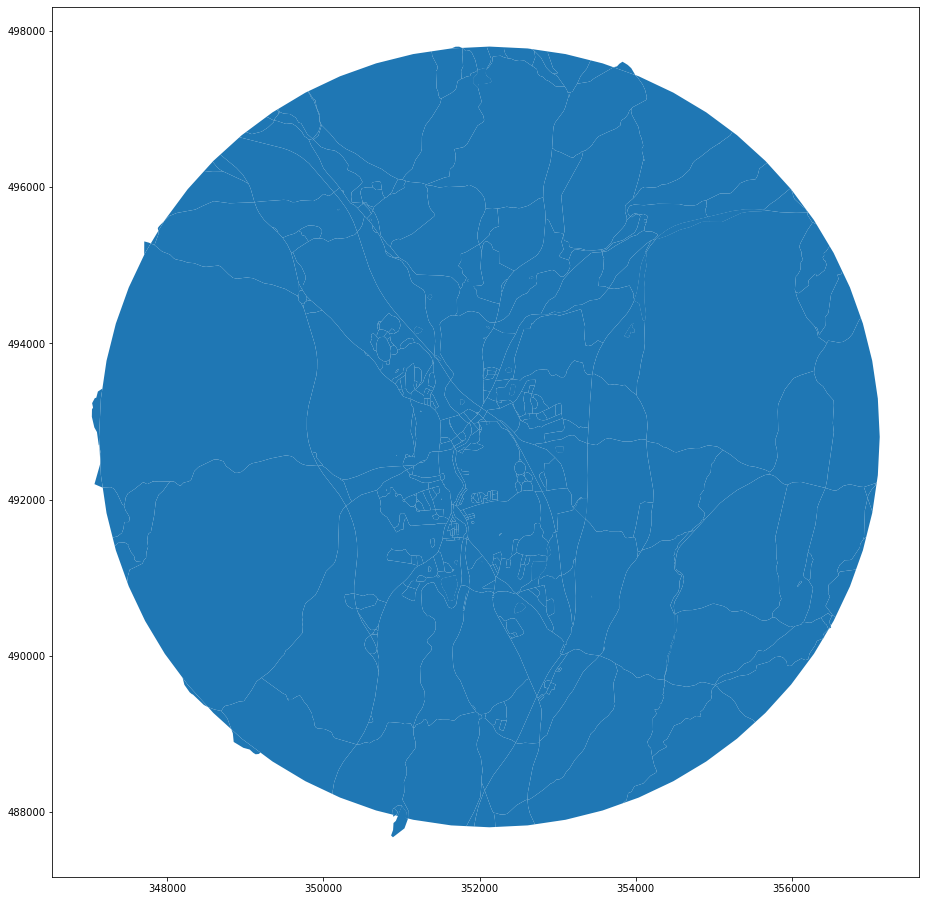

In [126]:
final_enclosures.plot(figsize=(16, 16))

In [127]:
client.close()